# Determining the cost of cars

Service for the sale of used cars "Not beaten, not beautiful" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. At your disposal are historical data: technical specifications, equipment and prices of cars. You need to build a model to determine the cost.

The customer is important:

- quality of prediction;
- prediction speed;
- studying time.

Basic steps:

1. Download data, file path: /datasets/autos.csv.

2. Explore the data. Fill in missing values ​​and handle anomalies in columns. If among the signs there are uninformative, remove them.

3. Prepare samples for model training.

4. Train different models, one of which is LightGBM, at least one is not boosted. For each model, try different hyperparameters.

5. Analyze training time, prediction time, and model quality.

6. Based on the criteria of the customer, choose the best model, check its quality on a test sample.

Notes:

- To assess the quality of models, use the RMSE metric.

- The RMSE metric value must be less than 2500.

- Learn the LightGBM library on your own and use it to build gradient boosting models.

- The execution time of a Jupyter Notebook code cell can be obtained with a special command. Find her.

- The gradient boosting model can take a long time to train, so change only two or three parameters for it.

- If Jupyter Notebook stops working, remove unnecessary variables with the del statement.

## Data preparation

### Import required modules and libraries

In [1]:
#!pip install ydata-profiling

In [2]:
#pip install lightgbm

In [3]:
#conda install -c conda-forge lightgbm

In [4]:
!pip install ydata_profiling

In [5]:
import lightgbm
import numpy as np
import pandas as pd
import re
from ydata_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Let's open the dataset and view data about it

In [6]:
try:
    data = pd.read_csv('/datasets/autos.csv', sep=',')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [7]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
data.shape

(354369, 16)

### Rename columns

In [9]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]
data['fuel_type'] = data['fuel_type'].replace(['gasoline'],'petrol')

Since Gasoline and Petrol mean gasoline, we can replace them with one of them

### We see several problems, we will work with some of them

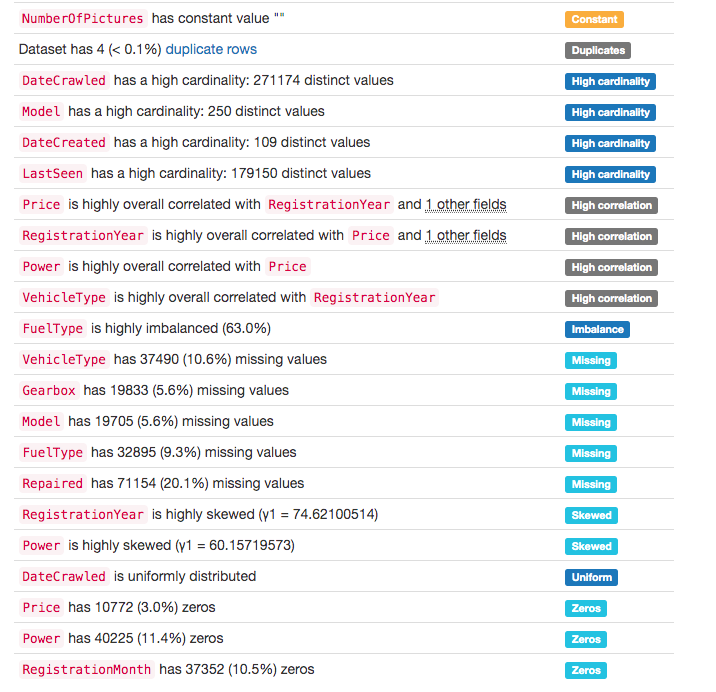

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

### Unnecessary / uninformative columns

The photo count column always has the same value, so you can delete it. We will also remove the columns with postal code, date of creation, date of last view, month of registration and date of downloading the profile from the database, since they are not informative

In [11]:
data['date_crawled'].max()

'2016-04-07 14:36:58'

In [12]:
data = data.drop(['number_of_pictures', 'postal_code', 'date_created',
                  'last_seen', 'registration_month', 'date_crawled'], axis=1)

### Remove duplicates

There are only four duplicates in the dataset, which is less than 0.1%, but we will remove them anyway

In [13]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308482 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              308482 non-null  int64 
 1   vehicle_type       273988 non-null  object
 2   registration_year  308482 non-null  int64 
 3   gearbox            291295 non-null  object
 4   power              308482 non-null  int64 
 5   model              290134 non-null  object
 6   kilometer          308482 non-null  int64 
 7   fuel_type          277718 non-null  object
 8   brand              308482 non-null  object
 9   repaired           244041 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.9+ MB


### Remove outliers

In the power column (more than 700 power is most likely an error)

In [14]:
data = data.query('power < 700')

And in the column with the year of issue. Since the latest download date is in 2016, we will limit ourselves to 2017

`data['date_crawled'].max() = '2016-04-07 14:36:58'`

In [15]:
data = data.loc[(data['registration_year'] < 2017) & (data['registration_year'] >= 1900)]

### Fill in the blanks

In [16]:
data.isna().sum()

price                    0
vehicle_type         20851
registration_year        0
gearbox              15357
power                    0
model                16331
kilometer                0
fuel_type            25362
brand                    0
repaired             58417
dtype: int64

#### Let's look at the gaps in the "Car body type" column

In [17]:
data['vehicle_type'] = data.groupby(
    ['model', 'registration_year'], dropna=False)['vehicle_type'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "unknown")))

In [18]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


#### There are also gaps in the power column.

In [19]:
data['power'] = data.groupby(['model', 'registration_year'], dropna=False)['power'].transform(
    lambda x: x.mask(x==0, x[x!=0].median() if x[x!=0].count()!=0 else 0))

In [20]:
data['power']

0          75.0
1         190.0
2         163.0
3          75.0
4          69.0
          ...  
354364     95.0
354365    131.0
354366    101.0
354367    102.0
354368    100.0
Name: power, Length: 294527, dtype: float64

#### And fill in the anomalies in the price column

In [21]:
data[data['price'] <100]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50.0,other,40000,petrol,volkswagen,no
40,0,small,1990,NaN,60.0,corsa,150000,petrol,opel,NaN
59,1,suv,1994,manual,286.0,NaN,150000,NaN,sonstige_autos,NaN
89,1,sedan,1995,manual,113.0,e_klasse,150000,petrol,mercedes_benz,no
115,0,small,1999,NaN,101.0,NaN,5000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354238,0,small,2002,manual,60.0,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53.0,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37.0,arosa,150000,petrol,seat,yes
354309,99,small,1999,manual,60.0,arosa,150000,petrol,seat,yes


Most likely a price mistake.

In [22]:
len(data[data['price'] < 100]) / len(data)

0.03546024642902009

The number of these ads is 3%, we will remove them

In [23]:
data = data[data['price'] > 100]

#### Fill in the gaps in the gearbox column

In [24]:
data['gearbox'] = data.groupby(
    ['model', 'registration_year', 'power'], dropna=False)['gearbox'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "unknown")))

#### Fill in the gaps in the column with the model

In [25]:
data['model'] = data.groupby(
    ['brand', 'registration_year', 'power'], dropna=False)['model'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "unknown")))

#### Fill in the blanks in the fuel type column

In [26]:
data['fuel_type'] = data.groupby(
    ['model', 'registration_year', 'power'], dropna=False)['fuel_type'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "unknown")))

#### Fill in the gaps in the repair data column

In [27]:
data['repaired'] = data.groupby(
    ['model', 'brand', 'registration_year', 'power', 'kilometer', 'fuel_type', 'gearbox', 'price'], dropna=False)['repaired'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else "unknown")))

In [28]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283163 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              283163 non-null  int64  
 1   vehicle_type       283163 non-null  object 
 2   registration_year  283163 non-null  int64  
 3   gearbox            283163 non-null  object 
 4   power              283163 non-null  float64
 5   model              283163 non-null  object 
 6   kilometer          283163 non-null  int64  
 7   fuel_type          283163 non-null  object 
 8   brand              283163 non-null  object 
 9   repaired           283163 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 23.8+ MB


### Conclusion

In this section, we performed data preprocessing. At the input, we received a table with more than 350 thousand rows and 16 columns. We changed the column names to more readable lowercase, removed uninformative columns, filled in the gaps, and got rid of anomalies. Removed duplicates. As a result, we have a table with 283 thousand rows and 10 columns.

## Model training

Let's designate the column with the price as the target feature, and the rest as `features`

In [30]:
target = data['price']
features = data.drop('price', axis=1)

### Divide the samples into training and test

In [31]:
target = data['price']
features = data.drop('price', axis=1)

(features_tr_val, features_test, target_tr_val, target_test
) = train_test_split(features, target, test_size=0.2, random_state=12345) 
(features_train, features_valid, target_train, target_valid
) = train_test_split(features_tr_val, target_tr_val, test_size=0.25,
                    random_state=12345)

display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)
display(target_train.shape)
display(target_valid.shape)
display(target_test.shape)

(169897, 9)

(56633, 9)

(56633, 9)

(169897,)

(56633,)

(56633,)

### Divide columns into types - categorical and numeric

In [32]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,75.0,golf,150000,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190.0,a6,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,skoda,no


In [33]:
cat_cols = features.select_dtypes(exclude=np.number).columns.tolist()
num_cols = data.drop(['price'] + cat_cols, axis=1).select_dtypes(include=np.number).columns.tolist()

display(cat_cols)
display(num_cols)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

['registration_year', 'power', 'kilometer']

### Let's convert the categorical values ​​of the columns into quantitative

Let's train the encoder on the train sample

In [34]:
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')
ohe.fit(features_train[cat_cols])

OneHotEncoder(drop='first', sparse=False)

In [35]:
features_train_ohe = features_train.drop(columns=cat_cols).copy()
features_train_ohe[ohe.get_feature_names_out()] = ohe.transform(
    features_train[cat_cols])

features_valid_ohe = features_valid.drop(columns=cat_cols).copy()
features_valid_ohe[ohe.get_feature_names_out()] = ohe.transform(
    features_valid[cat_cols])

features_test_ohe = features_test.drop(columns=cat_cols).copy()
features_test_ohe[ohe.get_feature_names_out()] = ohe.transform(
    features_test[cat_cols])

/var/folders/kr/l8l6g3315gj_6wm9tbxwybbh0000gn/T/ipykernel_2962/2713683421.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_ohe[ohe.get_feature_names_out()] = ohe.transform(
/var/folders/kr/l8l6g3315gj_6wm9tbxwybbh0000gn/T/ipykernel_2962/2713683421.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_ohe[ohe.get_feature_names_out()] = ohe.transform(
/var/folders/kr/l8l6g3315gj_6wm9tbxwybbh0000gn/T/ipykernel_2962/2713683421.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

### Scale features

In [36]:
scaler = StandardScaler()
scaler.fit(features_train[num_cols])
features_train[num_cols] = scaler.transform(features_train[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

features_valid[num_cols] = scaler.transform(features_valid[num_cols])

### Train a linear regression model

In [37]:
model = LinearRegression()
model.fit(features_train_ohe, target_train)
predictions_valid_ohe = model.predict(features_valid_ohe)
rmse = mean_squared_error(target_valid, predictions_valid_ohe)**0.5
rmse

2786.185256990842

RMSE is greater than the required value of 2500

### Train the decision tree model

In [43]:
best_rmse = 100000
best_depth = 0
for depth in range(1, 30, 2):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth);
    model.fit(features_train_ohe, target_train);
    predictions_valid_tree = model.predict(features_valid_ohe);
    rmse_tree = mean_squared_error(target_valid, predictions_valid_tree)**0.5
    print('\nDepth:', depth)
    print('RMSE log file:', rmse_tree)
    if rmse_tree < best_rmse:
        best_rmse = rmse_tree
        best_depth = depth
        
print('\n Size rmse = {} shape depth = {}'.format(best_rmse, best_depth))


Depth: 1
RMSE log file: 3734.1925140036383

Depth: 3
RMSE log file: 3015.2990418341733

Depth: 5
RMSE log file: 2517.532183265178

Depth: 7
RMSE log file: 2259.9543000792482

Depth: 9
RMSE log file: 2115.0317661034774

Depth: 11
RMSE log file: 2031.3308386057422

Depth: 13
RMSE log file: 1992.8134435857103

Depth: 15
RMSE log file: 1972.810446895091

Depth: 17
RMSE log file: 1983.58238962233

Depth: 19
RMSE log file: 1991.4940464250085

Depth: 21
RMSE log file: 2012.5586229765547

Depth: 23
RMSE log file: 2020.279859413044

Depth: 25
RMSE log file: 2045.140422306163

Depth: 27
RMSE log file: 2045.420081381642

Depth: 29
RMSE log file: 2058.200770218398

 Size rmse = 1972.810446895091 shape depth = 15


RMSE = 1972 at depth 15 on the decision tree model is much less than on linear regression

### We train a Lightgbm model

Let's translate the categorical features into the category type, which is required for LightGBM

In [44]:
for cat in features_train.columns:
    if features_train[cat].dtype == 'object':
        features_train[cat] = features_train[cat].astype('category')

In [45]:
for cat in features_valid.columns:
    if features_valid[cat].dtype == 'object':
        features_valid[cat] = features_valid[cat].astype('category')

Train the Model

In [46]:
model = lightgbm.LGBMRegressor(random_state=12345)
model.fit(features_train, target_train)
predictions_valid_lgbm = model.predict(features_valid)
rmse_lgbm = mean_squared_error(target_valid, predictions_valid_lgbm)**0.5
rmse_lgbm

1703.0150652819086

RMSE = 1703, even less than the decision tree

In [47]:
model = lightgbm.LGBMRegressor(random_state=12345, n_jobs=4)

light_model=GridSearchCV(estimator=model,
                         param_grid={
                             'n_estimators': [100, 500, 1000],
                             'num_leaves': [n for n in range(20, 200, 40)]},
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         verbose=3)

light_model.fit(features_train, target_train)
display(light_model.best_params_)
display(light_model.best_score_*-1)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END n_estimators=100, num_leaves=20;, score=-1726.991 total time=   1.3s
[CV 2/3] END n_estimators=100, num_leaves=20;, score=-1725.611 total time=   1.1s
[CV 3/3] END n_estimators=100, num_leaves=20;, score=-1713.629 total time=   1.1s
[CV 1/3] END n_estimators=100, num_leaves=60;, score=-1678.166 total time=   1.5s
[CV 2/3] END n_estimators=100, num_leaves=60;, score=-1678.934 total time=   1.6s
[CV 3/3] END n_estimators=100, num_leaves=60;, score=-1671.795 total time=   1.6s
[CV 1/3] END n_estimators=100, num_leaves=100;, score=-1668.097 total time=   2.0s
[CV 2/3] END n_estimators=100, num_leaves=100;, score=-1668.048 total time=   2.2s
[CV 3/3] END n_estimators=100, num_leaves=100;, score=-1654.536 total time=   2.0s
[CV 1/3] END n_estimators=100, num_leaves=140;, score=-1658.226 total time=   2.3s
[CV 2/3] END n_estimators=100, num_leaves=140;, score=-1659.556 total time=   2.4s
[CV 3/3] END n_estimators=100, n

{'n_estimators': 500, 'num_leaves': 100}

1651.3649494339618

In [48]:
best_light_model = lightgbm.LGBMRegressor(random_state=12345, n_estimators = 500, num_leaves = 100)
best_light_model.fit(features_train, target_train)
predictions_valid_lgbm = best_light_model.predict(features_valid)
rmse_lgbm = mean_squared_error(target_valid, predictions_valid_lgbm)**0.5
rmse_lgbm

1632.507375210857

### Conclusion

We trained different models, selected hyperparameters for them and found that

with a linear regression model RMSE = 2760

with model decision tree RMSE = 1972 with depth = 15

with LightGBM model with hyperparameters 'n_estimators': 500, 'num_leaves': 100 gives rmse value: 1632.

## Analysis of models

### Linear regression

Find the training time for the linear regression model

In [49]:
%%time
model = LinearRegression()
model.fit(features_train_ohe, target_train)

CPU times: user 12.4 s, sys: 4.39 s, total: 16.8 s
Wall time: 14.3 s


LinearRegression()

Let's build predictions on the validation set and find the cell execution time

In [50]:
%%time
predictions_valid_ohe = model.predict(features_valid_ohe)

CPU times: user 215 ms, sys: 205 ms, total: 420 ms
Wall time: 350 ms


### Find the training time for the decision tree model

In [51]:
%%time
model = DecisionTreeRegressor(random_state=12345, max_depth=15)
model.fit(features_train_ohe, target_train)

CPU times: user 5.31 s, sys: 978 ms, total: 6.28 s
Wall time: 6.26 s


DecisionTreeRegressor(max_depth=15, random_state=12345)

Let's build predictions on the validation set and find the cell execution time

In [52]:
%%time
predictions_valid_ohe = model.predict(features_valid_ohe)

CPU times: user 136 ms, sys: 123 ms, total: 258 ms
Wall time: 255 ms


### Find the training time for the Lightgbm model

In [53]:
%%time
model = lightgbm.LGBMRegressor(random_state=12345,
                          n_estimators=500,
                          num_leaves=100)
model.fit(features_train, target_train)

CPU times: user 22.5 s, sys: 549 ms, total: 23 s
Wall time: 6.24 s


LGBMRegressor(n_estimators=500, num_leaves=100, random_state=12345)

In [54]:
%%time
predictions_valid = model.predict(features_valid)

CPU times: user 6.67 s, sys: 81.5 ms, total: 6.75 s
Wall time: 3.26 s


### Let's look at what signs affect the price the most

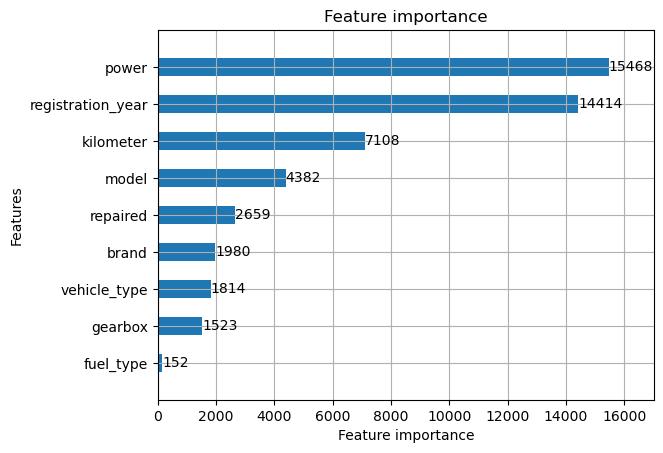

In [55]:
lightgbm.plot_importance(model, height=.5);

In [57]:
tabledata = [["Linear regression", "training", 13100, 10400],
             ["Linear regression", "prediction", 364, 361],
         ["Decision tree", "training", 6440, 6630],
         ["Decision tree", "prediction", 376, 380],
         ["LightGBM", "training", 21700, 6240],
         ["LightGBM", "prediction", 5330, 1870]]
df = pd.DataFrame(tabledata, columns=["Model", "Runtime", "CPU-times, ms", "Wall time"])
df = df.set_index('Model')
df.index.names = [None]
df.sort_values(by=['CPU-times, ms', 'Runtime'], ascending=False)

,Runtime,"CPU-times, ms",Wall time
LightGBM,training,21700,6240
Linear regression,training,13100,10400
Decision tree,training,6440,6630
LightGBM,prediction,5330,1870
Decision tree,prediction,376,380
Linear regression,prediction,364,361


The LightGBM model takes the longest to learn, linear regression is slightly faster, the decision tree is the fastest, and LightGBM also takes more time to predict

### Let's carry out the final testing of the best model on a test set that has not yet been used

In [58]:
model = lightgbm.LGBMRegressor(random_state=12345,
                          n_estimators=500,
                          num_leaves=100)
model.fit(features_train_ohe, target_train)
predictions_test_ohe = model.predict(features_test_ohe)
rmse_tree = mean_squared_error(target_test, predictions_test_ohe)**0.5
rmse_tree

1630.1571714930126

We got `rmse` = 1630.15, less than the given value of 2500, very good result

### Conclusion

At the input, we received a table with more than 350 thousand rows and 16 columns. We translated the column names into a more readable form, removed uninformative columns, filled in the gaps, and got rid of anomalies. Removed duplicates.

For the linear regression model, the categorical values ​​of the columns were converted into quantitative ones. As a result, we have a table with 281 thousand rows and 309 columns. For the decision tree model, ordinal coding was used, as a result, the number of columns for them did not change, and the selection of hyperparameters became faster. We trained different models, fitted hyperparameters for them, and found that the LightGBM model with hyperparameters 'n_estimators': 500, 'num_leaves': 100 gives the lowest rmse value: 1630.

We analyzed all the models and found that the decision tree model is the fastest to learn. The linear regression model, like the LightGBM model, takes a little longer to train, with the best performance being obtained from the LightGBM model.

Based on the customer's requirements for learning rate, prediction and model quality, we recommend the LightGBM model because it has the most optimal performance.